In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.losses import mean_absolute_error

from lib import LSTM_model

Using TensorFlow backend.


In [2]:
plt.ion()
plt.style.use('seaborn-darkgrid')

In [3]:
plt.rcParams["figure.figsize"] = (18,9)
plt.rcParams['lines.linewidth'] = 1

The data about the bitcoin price is available from two different sources: Bitstamp and Coinbase. While the former is larger in terms of timesteps, it also has more NaN values thus making it less suitable for the task given that the bitcoin market had less activity in that time range.

In [4]:
bs_df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2018-11-11.csv')

### Data adjustments

Having a glance over the data we can see that it shows stock market information (Close, Open, Volume.. values) of bitcoin at each minute. NaN values indicate that there was no activity (therefore we assume the prices remain the last valid value seen) during that minute while missing timestamps means that the data for that minute is missing therefore we decide to interpolate it

In [5]:
df = pd.read_csv('coinbaseUSD_1-min_data_2014-12-01_to_2018-11-11.csv',
                 dtype={
                     'Timestamp': np.int64,
                     'Open': np.float64,
                     'High': np.float64,
                     'Low': np.float64,
                     'Close': np.float64,
                     'Volume_(BTC)': np.float64,
                     'Volume_(Currency)': np.float64,
                     'Weighted_Price': np.float64
                 }).sort_values(by=['Timestamp'])

df['Open'].fillna(inplace=True, method='ffill')
df['Close'].fillna(inplace=True, method='ffill')
df['High'].fillna(inplace=True, method='ffill')
df['Low'].fillna(inplace=True, method='ffill')
df['Volume_(BTC)'].fillna(0, inplace=True)
df['Volume_(Currency)'].fillna(0, inplace=True)

In the following steps we ensure that data is truly present at each minute from 2014-12-01 to 2018-11-11 and then we interpolate 

In [6]:
df = df.set_index('Timestamp')

# Ensure that there exists an instance for each minute
df = df.reindex(range(df.index[0], df.index[-1], 60), fill_value=np.nan)

df.reset_index(level=0, inplace=True)

df['Timestamp'] = df['Timestamp'].apply(lambda t: datetime.utcfromtimestamp(t))

### First 20 instances after the interpolation

In [7]:
df.interpolate(inplace=True)
df.head(20)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2014-12-01 05:33:00,300.0,300.0,300.0,300.0,0.01,3.0,300.000000
1,2014-12-01 05:34:00,300.0,300.0,300.0,300.0,0.00,0.0,300.000000
2,2014-12-01 05:35:00,300.0,300.0,300.0,300.0,0.00,0.0,300.000000
3,2014-12-01 05:36:00,300.0,300.0,300.0,300.0,0.00,0.0,300.000000
4,2014-12-01 05:37:00,300.0,300.0,300.0,300.0,0.00,0.0,300.000000
5,2014-12-01 05:38:00,300.0,300.0,300.0,300.0,0.00,0.0,300.000000
6,2014-12-01 05:39:00,300.0,300.0,300.0,300.0,0.00,0.0,300.000000
7,2014-12-01 05:40:00,300.0,300.0,300.0,300.0,0.01,3.0,300.000000
8,2014-12-01 05:41:00,300.0,300.0,300.0,300.0,0.00,0.0,301.590909
9,2014-12-01 05:42:00,300.0,300.0,300.0,300.0,0.00,0.0,303.181818


Number of instances

In [8]:
len(df)

2074707

Text(0, 0.5, 'Mean Price ($)')

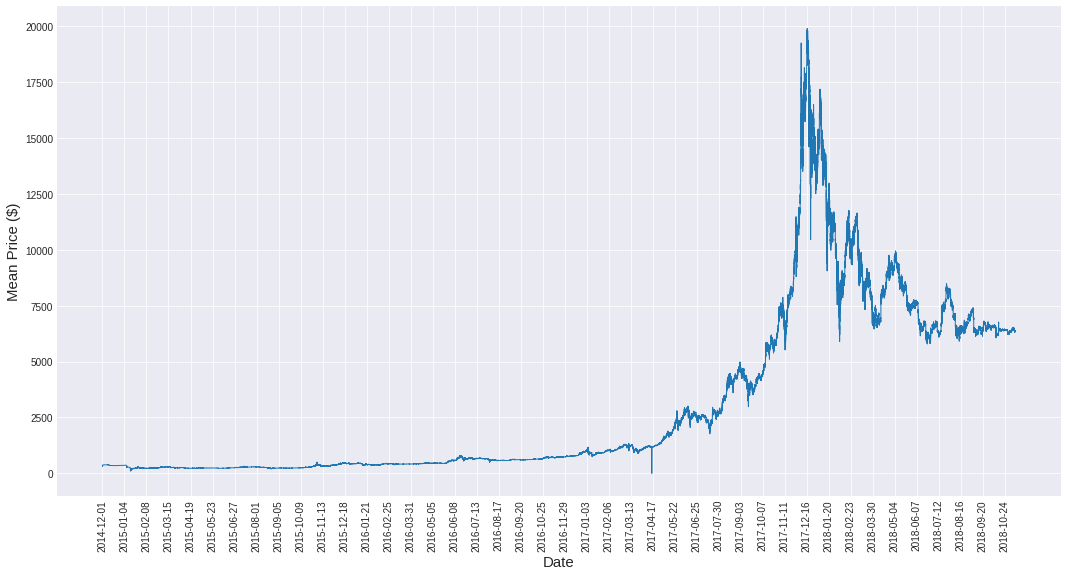

In [9]:
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
ts = df['Timestamp'].tolist()[::50000]
xticks = (t.strftime('%Y-%m-%d') for t in ts)
plt.xticks(range(0,df.shape[0],50000),xticks,rotation=90)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Mean Price ($)',fontsize=15)

## Observations

### Evaluating Time Series Forecasting

In time series forecasting we have to choose the input and the output of the model. We can choose for example to predict $x_{t + 1}$ at a given time $t$ by giving in input to the model $x_t$ or giving in input $(x_{t-k}, x_{t - k + 1},...,x_{t})$ where $k$ is the window size, i.e. how much of the past the predictor can observe. Both cases are called *One-Step Ahead* Forecasting.

This can be useful in some cases, such as weather forecasting. In the case of trading though, we would like to predict far in the future. This can be done by iteratively letting the model predict the next values based *not* on the actual values of the window but on the previously predicted values i.e. given in input $(\hat x_{t-k}, \hat x_{t - k + 1},..., \hat x_{t})$. This method might not work well if the model is trained in a one-step ahead fashion.

We must be careful on how we evaluate our model since what can happen is that we feed the network the actual data $(x_{t-k}, x_{t - k + 1},...,x_{t})$ for multiple values of $t$ producing the predicted values $\hat x_{t+1} \approx x_t, \hat x_{t+2} \approx x_{t+1}, \hat x_{t+3} \approx x_{t+2}, \hat x_{t+4} \approx x_{t+3}$ (similar to the *Persistence Model*) which produces a good result in terms of *Mean Absolute Error* (since the data has some inertia in fluctuatng) but not really useful given that at each timestep the model can see the previous *actual* data and thus does not depend by previous wrong predictions.

![lag](images/lag.png)

Alternatively we can perform a *Multi Step* Forecast i.e. letting the model predict the next $m$ values $x_{t+1}, ..., x_{t+m}$

### Data Preprocessing

Another issue we must consider is how to preprocess the data. We cannot normalize it over the full time period since given the spike of the BTC price in December 2017 a good portion of the data would be normalized close to 0.

A good way would be to normalize the data in the time window, i.e. by representing each datapoint in the window as a ratio (positive or negative) of increase/decrease in value with respect to the first data point of the window. In this case the data points will be values in the range $[-1, 1]$ (for appropriates values of the window size and if the data is not too volatile) thus a good activation function would be $tanh$.

Another way can be differencing the data which means mapping point $x_t$ to $x_t' = x_t - x_{t-1}$ and then normalize.

The windows can either overlap or not.

## Map Data to Day granularity

Given that the change of the values at the granularity of the minute is very small, we decide to group the data by day. We perform both 1 step ahead prediction and 5 steps ahead.

In [10]:
df['Date'] = df['Timestamp'].apply(lambda t: t.date())
daily_info = df.groupby('Date').agg({
    'Open': lambda opens: opens.iloc[0],     # Opening value of the day
    'Close': lambda closes: closes.iloc[-1], # Closing value of the day
    'Low' : np.min,                          # Lowest value of the day
    'High': np.max,                          # Highest value of the day
    'Volume_(BTC)': np.sum                   # Sum of the volumes of the minutes in the day
}).reset_index(level=0)
daily_info['Mean'] = (daily_info['High'] + daily_info['Close']) / 2
daily_info.head(20)

,Date,Open,Close,Low,High,Volume_(BTC),Mean
0,2014-12-01,300.000000,370.000000,300.000000,370.000000,0.056556,370.000000
1,2014-12-02,370.000000,378.000000,370.000000,378.000000,15.013600,378.000000
2,2014-12-03,378.000000,378.000000,377.010000,378.000000,0.546608,378.000000
3,2014-12-04,378.000000,377.516951,377.100000,378.000000,14.862718,377.758475
4,2014-12-05,377.517264,377.968047,377.517264,377.968047,19.541246,377.968047
5,2014-12-06,377.968361,377.026909,377.026909,378.000000,69.366556,377.513455
6,2014-12-07,377.029428,375.979636,375.979636,377.029428,179.692800,376.504532
7,2014-12-08,375.985646,376.261203,375.000000,376.270654,289.471801,376.265929
8,2014-12-09,376.284210,395.789505,376.274764,395.790466,182.990802,395.789985
9,2014-12-10,395.804021,368.564913,360.500000,398.000000,27.285516,383.282456


In [11]:
len(daily_info) # Number of days for which data is present or interpolated

1441

## Model

### Transform each window

Each window is "normalized" thus representing each value as percentage in increase or decrease of the first value in the window

$$
    \mathbf{w}' = \frac{\mathbf{w}}{w_0} - 1
$$

<img src="images/lstm.png" width="50%">

In [12]:
IN_TIMESTEPS  = 15
OUT_TIMESTEPS = 1
TRAIN_RATIO = 0.7
X_cols = ["Open", "Close", "Mean"]
Y_cols = ["Mean"]

EPOCHS = 10**3
BATCH_SZ = 256

In [13]:
def build_lstm_nn(timesteps, out_size, input_shape):
    return Sequential([
        LSTM(
            out_size,
            input_shape=(timesteps, input_shape))
    ])

In [14]:
model = LSTM_model(
    in_timesteps=IN_TIMESTEPS, out_timesteps=OUT_TIMESTEPS,
    x_cols=X_cols, y_cols=Y_cols, step_col="Date", train_ratio=TRAIN_RATIO, model = build_lstm_nn
).data(daily_info).fit(epochs=EPOCHS)

Epoch 1/1000
998/998 [==============================] - 0s 488us/step - loss: 0.0504
Epoch 2/1000
998/998 [==============================] - 0s 38us/step - loss: 0.0490
Epoch 3/1000
998/998 [==============================] - 0s 40us/step - loss: 0.0479
Epoch 4/1000
998/998 [==============================] - 0s 33us/step - loss: 0.0470
Epoch 5/1000
998/998 [==============================] - 0s 33us/step - loss: 0.0462
Epoch 6/1000
998/998 [==============================] - 0s 36us/step - loss: 0.0453
Epoch 7/1000
998/998 [==============================] - 0s 34us/step - loss: 0.0444
Epoch 8/1000
998/998 [==============================] - 0s 30us/step - loss: 0.0436
Epoch 9/1000
998/998 [==============================] - 0s 30us/step - loss: 0.0428
Epoch 10/1000
998/998 [==============================] - 0s 30us/step - loss: 0.0421
Epoch 11/1000
998/998 [==============================] - 0s 32us/step - loss: 0.0413
Epoch 12/1000
998/998 [==============================] - 0s 32us/step - l

998/998 [==============================] - 0s 32us/step - loss: 0.0309
Epoch 98/1000
998/998 [==============================] - 0s 30us/step - loss: 0.0308
Epoch 99/1000
998/998 [==============================] - 0s 26us/step - loss: 0.0308
Epoch 100/1000
998/998 [==============================] - 0s 28us/step - loss: 0.0307
Epoch 101/1000
998/998 [==============================] - 0s 35us/step - loss: 0.0307
Epoch 102/1000
998/998 [==============================] - 0s 28us/step - loss: 0.0306
Epoch 103/1000
998/998 [==============================] - 0s 30us/step - loss: 0.0306
Epoch 104/1000
998/998 [==============================] - 0s 29us/step - loss: 0.0306
Epoch 105/1000
998/998 [==============================] - 0s 28us/step - loss: 0.0305
Epoch 106/1000
998/998 [==============================] - 0s 28us/step - loss: 0.0305
Epoch 107/1000
998/998 [==============================] - 0s 31us/step - loss: 0.0304
Epoch 108/1000
998/998 [==============================] - 0s 29us/step 

998/998 [==============================] - 0s 32us/step - loss: 0.0272
Epoch 193/1000
998/998 [==============================] - 0s 34us/step - loss: 0.0271
Epoch 194/1000
998/998 [==============================] - 0s 33us/step - loss: 0.0271
Epoch 195/1000
998/998 [==============================] - 0s 32us/step - loss: 0.0271
Epoch 196/1000
998/998 [==============================] - 0s 31us/step - loss: 0.0270
Epoch 197/1000
998/998 [==============================] - 0s 32us/step - loss: 0.0270
Epoch 198/1000
998/998 [==============================] - 0s 31us/step - loss: 0.0270
Epoch 199/1000
998/998 [==============================] - 0s 32us/step - loss: 0.0269
Epoch 200/1000
998/998 [==============================] - 0s 37us/step - loss: 0.0269
Epoch 201/1000
998/998 [==============================] - 0s 31us/step - loss: 0.0269
Epoch 202/1000
998/998 [==============================] - 0s 33us/step - loss: 0.0268
Epoch 203/1000
998/998 [==============================] - 0s 28us/ste

998/998 [==============================] - 0s 31us/step - loss: 0.0244
Epoch 288/1000
998/998 [==============================] - 0s 28us/step - loss: 0.0243
Epoch 289/1000
998/998 [==============================] - 0s 27us/step - loss: 0.0243
Epoch 290/1000
998/998 [==============================] - 0s 29us/step - loss: 0.0243
Epoch 291/1000
998/998 [==============================] - 0s 32us/step - loss: 0.0243
Epoch 292/1000
998/998 [==============================] - 0s 29us/step - loss: 0.0242
Epoch 293/1000
998/998 [==============================] - 0s 31us/step - loss: 0.0242
Epoch 294/1000
998/998 [==============================] - 0s 26us/step - loss: 0.0242
Epoch 295/1000
998/998 [==============================] - 0s 32us/step - loss: 0.0242
Epoch 296/1000
998/998 [==============================] - 0s 31us/step - loss: 0.0242
Epoch 297/1000
998/998 [==============================] - 0s 28us/step - loss: 0.0241
Epoch 298/1000
998/998 [==============================] - 0s 27us/ste

998/998 [==============================] - 0s 31us/step - loss: 0.0224
Epoch 383/1000
998/998 [==============================] - 0s 30us/step - loss: 0.0224
Epoch 384/1000
998/998 [==============================] - 0s 27us/step - loss: 0.0224
Epoch 385/1000
998/998 [==============================] - 0s 28us/step - loss: 0.0223
Epoch 386/1000
998/998 [==============================] - 0s 30us/step - loss: 0.0223
Epoch 387/1000
998/998 [==============================] - 0s 28us/step - loss: 0.0223
Epoch 388/1000
998/998 [==============================] - 0s 27us/step - loss: 0.0223
Epoch 389/1000
998/998 [==============================] - 0s 29us/step - loss: 0.0223
Epoch 390/1000
998/998 [==============================] - 0s 26us/step - loss: 0.0223
Epoch 391/1000
998/998 [==============================] - 0s 29us/step - loss: 0.0222
Epoch 392/1000
998/998 [==============================] - 0s 27us/step - loss: 0.0222
Epoch 393/1000
998/998 [==============================] - 0s 27us/ste

998/998 [==============================] - 0s 29us/step - loss: 0.0210
Epoch 478/1000
998/998 [==============================] - 0s 31us/step - loss: 0.0210
Epoch 479/1000
998/998 [==============================] - 0s 27us/step - loss: 0.0210
Epoch 480/1000
998/998 [==============================] - 0s 28us/step - loss: 0.0210
Epoch 481/1000
998/998 [==============================] - 0s 28us/step - loss: 0.0210
Epoch 482/1000
998/998 [==============================] - 0s 28us/step - loss: 0.0210
Epoch 483/1000
998/998 [==============================] - 0s 27us/step - loss: 0.0210
Epoch 484/1000
998/998 [==============================] - 0s 26us/step - loss: 0.0209
Epoch 485/1000
998/998 [==============================] - 0s 26us/step - loss: 0.0209
Epoch 486/1000
998/998 [==============================] - 0s 24us/step - loss: 0.0209
Epoch 487/1000
998/998 [==============================] - 0s 28us/step - loss: 0.0209
Epoch 488/1000
998/998 [==============================] - 0s 31us/ste

998/998 [==============================] - 0s 27us/step - loss: 0.0202
Epoch 573/1000
998/998 [==============================] - 0s 29us/step - loss: 0.0202
Epoch 574/1000
998/998 [==============================] - 0s 34us/step - loss: 0.0202
Epoch 575/1000
998/998 [==============================] - 0s 36us/step - loss: 0.0202
Epoch 576/1000
998/998 [==============================] - 0s 32us/step - loss: 0.0202
Epoch 577/1000
998/998 [==============================] - 0s 32us/step - loss: 0.0202
Epoch 578/1000
998/998 [==============================] - 0s 33us/step - loss: 0.0202
Epoch 579/1000
998/998 [==============================] - 0s 32us/step - loss: 0.0202
Epoch 580/1000
998/998 [==============================] - 0s 33us/step - loss: 0.0202
Epoch 581/1000
998/998 [==============================] - 0s 31us/step - loss: 0.0202
Epoch 582/1000
998/998 [==============================] - 0s 35us/step - loss: 0.0202
Epoch 583/1000
998/998 [==============================] - 0s 33us/ste

998/998 [==============================] - 0s 28us/step - loss: 0.0198
Epoch 668/1000
998/998 [==============================] - 0s 26us/step - loss: 0.0198
Epoch 669/1000
998/998 [==============================] - 0s 26us/step - loss: 0.0198
Epoch 670/1000
998/998 [==============================] - 0s 26us/step - loss: 0.0198
Epoch 671/1000
998/998 [==============================] - 0s 27us/step - loss: 0.0198
Epoch 672/1000
998/998 [==============================] - 0s 27us/step - loss: 0.0198
Epoch 673/1000
998/998 [==============================] - 0s 30us/step - loss: 0.0198
Epoch 674/1000
998/998 [==============================] - 0s 31us/step - loss: 0.0198
Epoch 675/1000
998/998 [==============================] - 0s 30us/step - loss: 0.0198
Epoch 676/1000
998/998 [==============================] - 0s 24us/step - loss: 0.0198
Epoch 677/1000
998/998 [==============================] - 0s 29us/step - loss: 0.0198
Epoch 678/1000
998/998 [==============================] - 0s 31us/ste

998/998 [==============================] - 0s 30us/step - loss: 0.0196
Epoch 763/1000
998/998 [==============================] - 0s 30us/step - loss: 0.0196
Epoch 764/1000
998/998 [==============================] - 0s 32us/step - loss: 0.0196
Epoch 765/1000
998/998 [==============================] - 0s 24us/step - loss: 0.0196
Epoch 766/1000
998/998 [==============================] - 0s 25us/step - loss: 0.0196
Epoch 767/1000
998/998 [==============================] - 0s 29us/step - loss: 0.0196
Epoch 768/1000
998/998 [==============================] - 0s 26us/step - loss: 0.0196
Epoch 769/1000
998/998 [==============================] - 0s 25us/step - loss: 0.0195
Epoch 770/1000
998/998 [==============================] - 0s 28us/step - loss: 0.0195
Epoch 771/1000
998/998 [==============================] - 0s 30us/step - loss: 0.0195
Epoch 772/1000
998/998 [==============================] - 0s 25us/step - loss: 0.0195
Epoch 773/1000
998/998 [==============================] - 0s 30us/ste

998/998 [==============================] - 0s 30us/step - loss: 0.0194
Epoch 858/1000
998/998 [==============================] - 0s 29us/step - loss: 0.0194
Epoch 859/1000
998/998 [==============================] - 0s 28us/step - loss: 0.0194
Epoch 860/1000
998/998 [==============================] - 0s 26us/step - loss: 0.0194
Epoch 861/1000
998/998 [==============================] - 0s 31us/step - loss: 0.0194
Epoch 862/1000
998/998 [==============================] - 0s 30us/step - loss: 0.0194
Epoch 863/1000
998/998 [==============================] - 0s 26us/step - loss: 0.0194
Epoch 864/1000
998/998 [==============================] - 0s 29us/step - loss: 0.0194
Epoch 865/1000
998/998 [==============================] - 0s 27us/step - loss: 0.0194
Epoch 866/1000
998/998 [==============================] - 0s 28us/step - loss: 0.0194
Epoch 867/1000
998/998 [==============================] - 0s 28us/step - loss: 0.0194
Epoch 868/1000
998/998 [==============================] - 0s 26us/ste

998/998 [==============================] - 0s 30us/step - loss: 0.0193
Epoch 953/1000
998/998 [==============================] - 0s 30us/step - loss: 0.0193
Epoch 954/1000
998/998 [==============================] - 0s 26us/step - loss: 0.0193
Epoch 955/1000
998/998 [==============================] - 0s 28us/step - loss: 0.0193
Epoch 956/1000
998/998 [==============================] - 0s 28us/step - loss: 0.0193
Epoch 957/1000
998/998 [==============================] - 0s 27us/step - loss: 0.0193
Epoch 958/1000
998/998 [==============================] - 0s 27us/step - loss: 0.0193
Epoch 959/1000
998/998 [==============================] - 0s 30us/step - loss: 0.0193
Epoch 960/1000
998/998 [==============================] - 0s 26us/step - loss: 0.0193
Epoch 961/1000
998/998 [==============================] - 0s 27us/step - loss: 0.0193
Epoch 962/1000
998/998 [==============================] - 0s 32us/step - loss: 0.0193
Epoch 963/1000
998/998 [==============================] - 0s 31us/ste

LSTM test MAE: 253.21439410777157,  LAG test MAE: 250.33459112149524
LSTM train MAE: 18.628049550641798


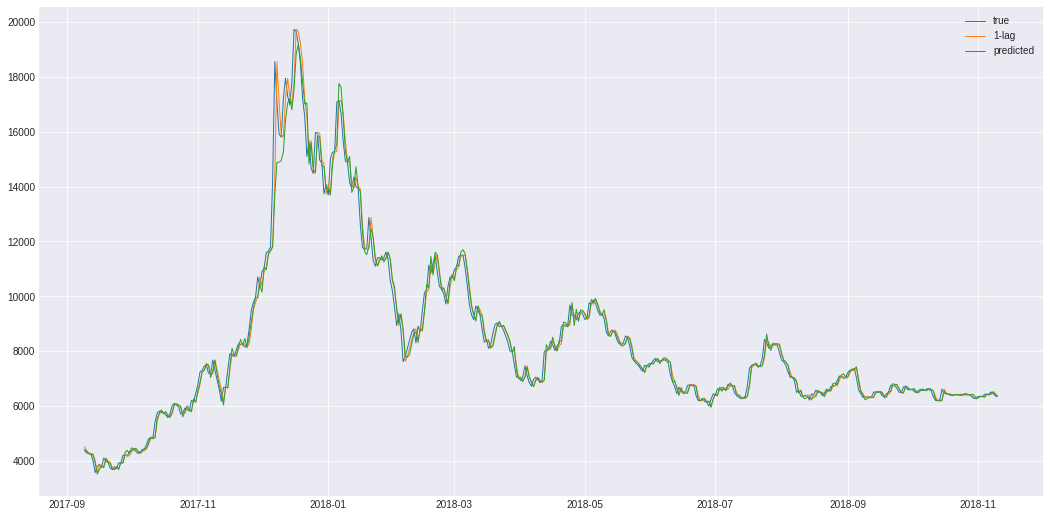

In [15]:
time, pred, true = model.get_pred_test_pair()
plt.plot(time, true, label='true')
plt.plot(time, model.orig_test[0][:,-1,2], label=str(OUT_TIMESTEPS) + '-lag')
plt.plot(time, pred, label='predicted')
plt.legend(loc='upper right', frameon=False)
print(f'LSTM test MAE: {model.get_test_mae()},  LAG test MAE: {np.abs(model.orig_test[0][:,-1,2] - true).mean()}')
print(f'LSTM train MAE: {model.get_train_mae()}')

As we can see the model is good in one step ahead prediction

### 4 Steps Ahead prediction

In [16]:
OUT_TIMESTEPS = 4

model = LSTM_model(
    in_timesteps=IN_TIMESTEPS, out_timesteps=OUT_TIMESTEPS,
    x_cols=X_cols, y_cols=Y_cols, step_col="Date", train_ratio=TRAIN_RATIO, model = build_lstm_nn
).data(daily_info).fit(epochs=EPOCHS)

Epoch 1/1000
996/996 [==============================] - 1s 516us/step - loss: 0.1077
Epoch 2/1000
996/996 [==============================] - 0s 34us/step - loss: 0.1056
Epoch 3/1000
996/996 [==============================] - 0s 36us/step - loss: 0.1035
Epoch 4/1000
996/996 [==============================] - 0s 30us/step - loss: 0.1016
Epoch 5/1000
996/996 [==============================] - 0s 36us/step - loss: 0.0998
Epoch 6/1000
996/996 [==============================] - 0s 37us/step - loss: 0.0983
Epoch 7/1000
996/996 [==============================] - 0s 31us/step - loss: 0.0968
Epoch 8/1000
996/996 [==============================] - 0s 32us/step - loss: 0.0954
Epoch 9/1000
996/996 [==============================] - 0s 31us/step - loss: 0.0939
Epoch 10/1000
996/996 [==============================] - 0s 33us/step - loss: 0.0925
Epoch 11/1000
996/996 [==============================] - 0s 35us/step - loss: 0.0911
Epoch 12/1000
996/996 [==============================] - 0s 31us/step - l

996/996 [==============================] - 0s 33us/step - loss: 0.0502
Epoch 98/1000
996/996 [==============================] - 0s 30us/step - loss: 0.0501
Epoch 99/1000
996/996 [==============================] - 0s 30us/step - loss: 0.0500
Epoch 100/1000
996/996 [==============================] - 0s 24us/step - loss: 0.0499
Epoch 101/1000
996/996 [==============================] - 0s 28us/step - loss: 0.0498
Epoch 102/1000
996/996 [==============================] - 0s 32us/step - loss: 0.0497
Epoch 103/1000
996/996 [==============================] - 0s 32us/step - loss: 0.0496
Epoch 104/1000
996/996 [==============================] - 0s 30us/step - loss: 0.0495
Epoch 105/1000
996/996 [==============================] - 0s 26us/step - loss: 0.0494
Epoch 106/1000
996/996 [==============================] - 0s 28us/step - loss: 0.0493
Epoch 107/1000
996/996 [==============================] - 0s 30us/step - loss: 0.0492
Epoch 108/1000
996/996 [==============================] - 0s 34us/step 

996/996 [==============================] - 0s 28us/step - loss: 0.0439
Epoch 193/1000
996/996 [==============================] - 0s 31us/step - loss: 0.0439
Epoch 194/1000
996/996 [==============================] - 0s 29us/step - loss: 0.0438
Epoch 195/1000
996/996 [==============================] - 0s 29us/step - loss: 0.0438
Epoch 196/1000
996/996 [==============================] - 0s 28us/step - loss: 0.0438
Epoch 197/1000
996/996 [==============================] - 0s 28us/step - loss: 0.0437
Epoch 198/1000
996/996 [==============================] - 0s 29us/step - loss: 0.0437
Epoch 199/1000
996/996 [==============================] - 0s 27us/step - loss: 0.0436
Epoch 200/1000
996/996 [==============================] - 0s 27us/step - loss: 0.0436
Epoch 201/1000
996/996 [==============================] - 0s 25us/step - loss: 0.0436
Epoch 202/1000
996/996 [==============================] - 0s 33us/step - loss: 0.0435
Epoch 203/1000
996/996 [==============================] - 0s 26us/ste

996/996 [==============================] - 0s 30us/step - loss: 0.0407
Epoch 288/1000
996/996 [==============================] - 0s 30us/step - loss: 0.0407
Epoch 289/1000
996/996 [==============================] - 0s 25us/step - loss: 0.0406
Epoch 290/1000
996/996 [==============================] - 0s 27us/step - loss: 0.0406
Epoch 291/1000
996/996 [==============================] - 0s 27us/step - loss: 0.0406
Epoch 292/1000
996/996 [==============================] - 0s 27us/step - loss: 0.0406
Epoch 293/1000
996/996 [==============================] - 0s 28us/step - loss: 0.0405
Epoch 294/1000
996/996 [==============================] - 0s 32us/step - loss: 0.0405
Epoch 295/1000
996/996 [==============================] - 0s 33us/step - loss: 0.0405
Epoch 296/1000
996/996 [==============================] - 0s 27us/step - loss: 0.0405
Epoch 297/1000
996/996 [==============================] - 0s 28us/step - loss: 0.0404
Epoch 298/1000
996/996 [==============================] - 0s 28us/ste

996/996 [==============================] - 0s 34us/step - loss: 0.0387
Epoch 383/1000
996/996 [==============================] - 0s 30us/step - loss: 0.0386
Epoch 384/1000
996/996 [==============================] - 0s 24us/step - loss: 0.0386
Epoch 385/1000
996/996 [==============================] - 0s 28us/step - loss: 0.0386
Epoch 386/1000
996/996 [==============================] - 0s 32us/step - loss: 0.0386
Epoch 387/1000
996/996 [==============================] - 0s 28us/step - loss: 0.0386
Epoch 388/1000
996/996 [==============================] - 0s 27us/step - loss: 0.0386
Epoch 389/1000
996/996 [==============================] - 0s 27us/step - loss: 0.0386
Epoch 390/1000
996/996 [==============================] - 0s 27us/step - loss: 0.0385
Epoch 391/1000
996/996 [==============================] - 0s 28us/step - loss: 0.0385
Epoch 392/1000
996/996 [==============================] - 0s 25us/step - loss: 0.0385
Epoch 393/1000
996/996 [==============================] - 0s 32us/ste

996/996 [==============================] - 0s 31us/step - loss: 0.0372
Epoch 478/1000
996/996 [==============================] - 0s 32us/step - loss: 0.0372
Epoch 479/1000
996/996 [==============================] - 0s 28us/step - loss: 0.0372
Epoch 480/1000
996/996 [==============================] - 0s 26us/step - loss: 0.0371
Epoch 481/1000
996/996 [==============================] - 0s 31us/step - loss: 0.0371
Epoch 482/1000
996/996 [==============================] - 0s 30us/step - loss: 0.0371
Epoch 483/1000
996/996 [==============================] - 0s 24us/step - loss: 0.0371
Epoch 484/1000
996/996 [==============================] - 0s 26us/step - loss: 0.0371
Epoch 485/1000
996/996 [==============================] - 0s 30us/step - loss: 0.0371
Epoch 486/1000
996/996 [==============================] - 0s 32us/step - loss: 0.0371
Epoch 487/1000
996/996 [==============================] - 0s 26us/step - loss: 0.0371
Epoch 488/1000
996/996 [==============================] - 0s 25us/ste

996/996 [==============================] - 0s 28us/step - loss: 0.0360
Epoch 573/1000
996/996 [==============================] - 0s 31us/step - loss: 0.0360
Epoch 574/1000
996/996 [==============================] - 0s 29us/step - loss: 0.0360
Epoch 575/1000
996/996 [==============================] - 0s 30us/step - loss: 0.0360
Epoch 576/1000
996/996 [==============================] - 0s 26us/step - loss: 0.0360
Epoch 577/1000
996/996 [==============================] - 0s 29us/step - loss: 0.0360
Epoch 578/1000
996/996 [==============================] - 0s 28us/step - loss: 0.0359
Epoch 579/1000
996/996 [==============================] - 0s 29us/step - loss: 0.0359
Epoch 580/1000
996/996 [==============================] - 0s 30us/step - loss: 0.0359
Epoch 581/1000
996/996 [==============================] - 0s 30us/step - loss: 0.0359
Epoch 582/1000
996/996 [==============================] - 0s 27us/step - loss: 0.0359
Epoch 583/1000
996/996 [==============================] - 0s 27us/ste

996/996 [==============================] - 0s 28us/step - loss: 0.0351
Epoch 668/1000
996/996 [==============================] - 0s 26us/step - loss: 0.0351
Epoch 669/1000
996/996 [==============================] - 0s 28us/step - loss: 0.0351
Epoch 670/1000
996/996 [==============================] - 0s 31us/step - loss: 0.0351
Epoch 671/1000
996/996 [==============================] - 0s 29us/step - loss: 0.0351
Epoch 672/1000
996/996 [==============================] - 0s 25us/step - loss: 0.0351
Epoch 673/1000
996/996 [==============================] - 0s 28us/step - loss: 0.0351
Epoch 674/1000
996/996 [==============================] - 0s 29us/step - loss: 0.0351
Epoch 675/1000
996/996 [==============================] - 0s 29us/step - loss: 0.0351
Epoch 676/1000
996/996 [==============================] - 0s 26us/step - loss: 0.0351
Epoch 677/1000
996/996 [==============================] - 0s 29us/step - loss: 0.0351
Epoch 678/1000
996/996 [==============================] - 0s 29us/ste

996/996 [==============================] - 0s 31us/step - loss: 0.0345
Epoch 763/1000
996/996 [==============================] - 0s 28us/step - loss: 0.0345
Epoch 764/1000
996/996 [==============================] - 0s 28us/step - loss: 0.0345
Epoch 765/1000
996/996 [==============================] - 0s 28us/step - loss: 0.0345
Epoch 766/1000
996/996 [==============================] - 0s 32us/step - loss: 0.0345
Epoch 767/1000
996/996 [==============================] - 0s 30us/step - loss: 0.0345
Epoch 768/1000
996/996 [==============================] - 0s 27us/step - loss: 0.0345
Epoch 769/1000
996/996 [==============================] - 0s 25us/step - loss: 0.0345
Epoch 770/1000
996/996 [==============================] - 0s 27us/step - loss: 0.0345
Epoch 771/1000
996/996 [==============================] - 0s 28us/step - loss: 0.0345
Epoch 772/1000
996/996 [==============================] - 0s 27us/step - loss: 0.0345
Epoch 773/1000
996/996 [==============================] - 0s 31us/ste

996/996 [==============================] - 0s 27us/step - loss: 0.0342
Epoch 858/1000
996/996 [==============================] - 0s 29us/step - loss: 0.0342
Epoch 859/1000
996/996 [==============================] - 0s 30us/step - loss: 0.0342
Epoch 860/1000
996/996 [==============================] - 0s 31us/step - loss: 0.0342
Epoch 861/1000
996/996 [==============================] - 0s 29us/step - loss: 0.0342
Epoch 862/1000
996/996 [==============================] - 0s 26us/step - loss: 0.0342
Epoch 863/1000
996/996 [==============================] - 0s 28us/step - loss: 0.0342
Epoch 864/1000
996/996 [==============================] - 0s 31us/step - loss: 0.0342
Epoch 865/1000
996/996 [==============================] - 0s 28us/step - loss: 0.0342
Epoch 866/1000
996/996 [==============================] - 0s 29us/step - loss: 0.0342
Epoch 867/1000
996/996 [==============================] - 0s 33us/step - loss: 0.0342
Epoch 868/1000
996/996 [==============================] - 0s 27us/ste

996/996 [==============================] - 0s 32us/step - loss: 0.0340
Epoch 953/1000
996/996 [==============================] - 0s 29us/step - loss: 0.0340
Epoch 954/1000
996/996 [==============================] - 0s 26us/step - loss: 0.0340
Epoch 955/1000
996/996 [==============================] - 0s 31us/step - loss: 0.0340
Epoch 956/1000
996/996 [==============================] - 0s 31us/step - loss: 0.0340
Epoch 957/1000
996/996 [==============================] - 0s 27us/step - loss: 0.0340
Epoch 958/1000
996/996 [==============================] - 0s 28us/step - loss: 0.0340
Epoch 959/1000
996/996 [==============================] - 0s 27us/step - loss: 0.0340
Epoch 960/1000
996/996 [==============================] - 0s 29us/step - loss: 0.0340
Epoch 961/1000
996/996 [==============================] - 0s 29us/step - loss: 0.0340
Epoch 962/1000
996/996 [==============================] - 0s 26us/step - loss: 0.0340
Epoch 963/1000
996/996 [==============================] - 0s 30us/ste

LSTM test MAE: 436.29357333619595,  LAG test MAE: 619.1642037470726
LSTM train MAE: 31.55578896886843


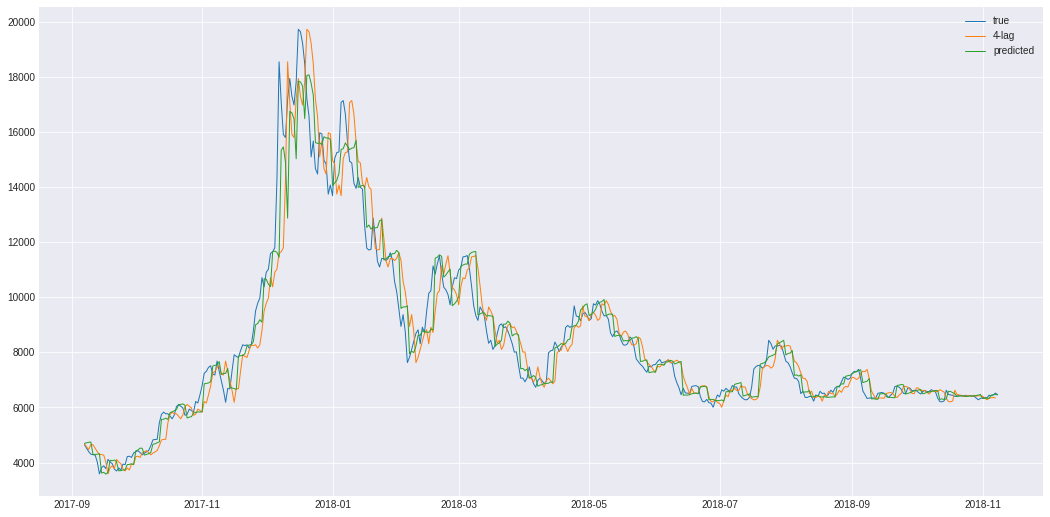

In [17]:
time, pred, true = model.get_pred_test_pair()
lag = model.orig_test[0][:,-OUT_TIMESTEPS::OUT_TIMESTEPS,-1].reshape(-1)
plt.plot(time, true, label='true')
plt.plot(time[:-1], lag, label=str(OUT_TIMESTEPS) + '-lag')
plt.plot(time, pred, label='predicted')
plt.legend(loc='upper right', frameon=False)
print(f'LSTM test MAE: {model.get_test_mae()},  LAG test MAE: {np.abs(lag - true[:-1]).mean()}')
print(f'LSTM train MAE: {model.get_train_mae()}')